In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_01 = cv2.imread('tsukuba/scene1.row3.col1.ppm')
img_02 = cv2.imread('tsukuba/scene1.row3.col2.ppm')
img_03 = cv2.imread('tsukuba/scene1.row3.col3.ppm')
img_04 = cv2.imread('tsukuba/scene1.row3.col4.ppm')
img_05 = cv2.imread('tsukuba/scene1.row3.col5.ppm')
images = [img_01, img_02, img_03, img_04, img_05]

In [4]:
# OpenCV's own implementation

def gaussian_pyramid_images_cv(img):
    p_imgs = [img]
    for i in np.arange(3):
        img = cv2.pyrDown(img)
        p_imgs.append(img)
    return p_imgs

# Selfimplemented Gaussian Pyramid function.
# Convolves with a Gaussian kernel and then removes all even rows and columns.
# Output is four images at a higher pyramid level and therefore lower resolution. 

def gaussian_pyramid_images(img):
    p_imgs = [img]
    
    for i in np.arange(3):
        img = cv2.GaussianBlur(img, (5,5), 2)
        img_new = []
        for i in np.arange(1,img.shape[0],2):
            img_row = []
            for j in np.arange(1,img.shape[1],2):
                img_row.append(img[i][j])
            img_new.append(img_row)
            
        img = np.array(img_new)
        p_imgs.append(img)
        
    return p_imgs


In [5]:
def plot_images(imgs):
    i, j = len(imgs)//2, len(imgs)//2
    fig, ax = plt.subplots(i, j, figsize=(15,15))
    ii, jj = np.meshgrid(np.arange(i), np.arange(j), indexing='ij')
    axes = [axis for axis in zip(ii.ravel(), jj.ravel())]
    for idx, axis in enumerate(axes):
        ax[axis].imshow(imgs[idx])
    plt.show()
        

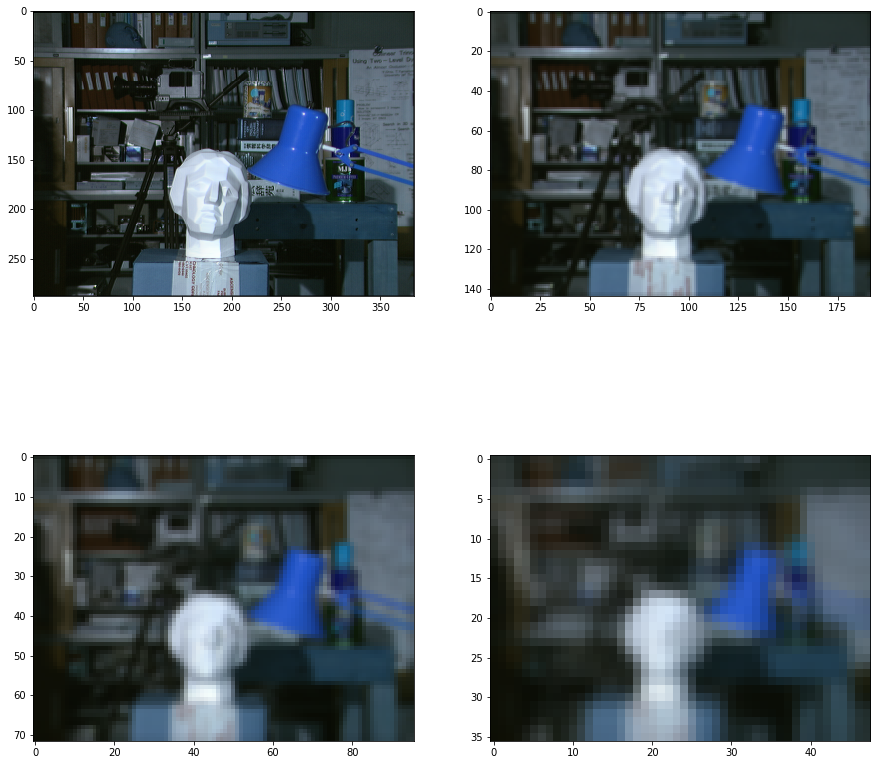

In [8]:
pyramid_images_img1 = gaussian_pyramid_images(img_01)
plot_images(pyramid_images_img1)

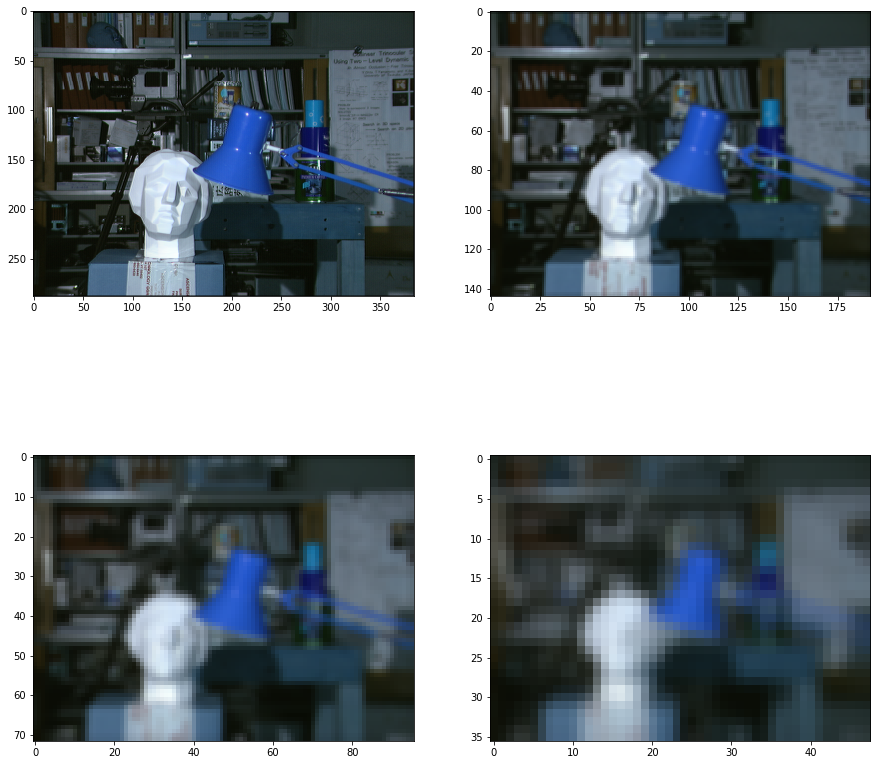

In [9]:
pyramid_images_img5 = gaussian_pyramid_images(img_05)
plot_images(pyramid_images_img5)

In [10]:

def create_patching_kernel(size):
    ii, jj = np.meshgrid(np.arange(-(size//2),size//2+1), np.arange(-(size//2),size//2+1), indexing='ij')
    return np.array([xy for xy in zip(jj.ravel(), ii.ravel())])

def create_image_grid(image):
    ii, jj = np.meshgrid(np.arange(image.shape[0]), np.arange(image.shape[1]), indexing='ij')
    image_grid = []
    for i in np.arange(image.shape[0]):
        image_grid.append([ij for ij in zip(ii[i].ravel(), jj[i].ravel())])
    return np.array(image_grid)

def create_patch_grid(img1, img2, size, M):
    index, column = img1.shape[0], img2.shape[1]
    patch_grid_coords = create_patching_kernel(size)
    final_patch_grid = []
    
    for i in np.arange(index):
        patch_space = [row for row in np.arange(i-(size//2),i+(size//2+1)) if row >= 0 and row <= index-1]
        patched_pixel_row = []
        for j in np.arange(column):
            patch_coords = np.array([np.array([i,j])+ij for ij in patch_grid_coords])
            patch_coords_adj = patch_coords[((patch_coords >= 0).all(axis=1)) \
                                            & ((patch_coords < [index,column]).all(axis=1))]
            patched_pixel_row.append(patch_coords_adj)
        final_patch_grid.append(patched_pixel_row)
        
    return np.array(final_patch_grid)
            

In [11]:
img_01.shape

(288, 384, 3)

In [12]:
patch_grid = create_patch_grid(img_01, img_02, 5, 5)
patch_grid.shape

(288, 384)

In [308]:
def match_search_horizontially(img1, img2, patch_grid, M):
    index, column = img1.shape[0], img1.shape[1]
    
    for i in np.arange(index):
        for j in np.arange(column):
            M_space = patch_grid[i,j-M:j+M]